In [15]:
import os
import sys
import pickle
import numpy as np
import essentia.standard as ess
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

#Container for analysis parameters
class AnalysisParams:
    def __init__(self,windowSize,hopSize,windowFunction,fftN,fs):
        '''
        windowSize: milliseconds,
        hopSize: milliseconds,
        windowFunction: str ('blackman','hanning',...)
        fftN: int
        '''
        self.windowSize = windowSize
        self.hopSize = hopSize
        self.windowFunction = windowFunction
        self.fftN=fftN
        self.fs=fs

def initiateData4File(file,root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData=dict();fileData['name']=file;fileData['path']=root;
    #Low level(LL) features
    fileData['NRG']=[];fileData['hpcp']=[];
    fileData['mean_hpcp_vector']=[];
    #data from annotations
    #fileData['mbid']=[];
    #fileData['tonic']=[];
    
    return fileData

#def extractAnnotationData(fileData,jsonFileName):
    #with open(jsonFileName) as json_file:
        #data = json.load(json_file)
        #fileData['mbid'].append(data[])
        

def computeLLFeatures(fileData,params):
    '''Computation of the low-level features
    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    params : instance of AnalysisParams
        Analysis parameters
    Modifies
    -------
    fileData 
    '''
    #Reading the wave file
    fs=params.fs
    x = ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate = fs)()
    x_dcremove = ess.DCRemoval()(x) ##preprocessing / apply DC removal for noisy regions
    
    #Windowing (first converting from msec to number of samples)
    windowSize=round(fs*params.windowSize/1000);windowSize=int(windowSize/2)*2#assuring window size is even
    hopSize=round(fs*params.hopSize/1000);hopSize=int(hopSize/2)*2#assuring hopSize is even
    
    #some necessary transformations
    spectrum = ess.Spectrum(size=windowSize) ##spectrum function to obtain spectral features from audio
    
    #Initializing lists for features
    NRG = [];
    hpcp=[];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize=windowSize, hopSize=hopSize, startFromZero=True):
        frame=ess.Windowing(size=windowSize, type=params.windowFunction)(frame)
        mX = spectrum(frame)
        mX[mX<np.finfo(float).eps]=np.finfo(float).eps

        #Tonal features
        freq,mag = ess.SpectralPeaks()(mX) #extract frequency and magnitude information by finding the spectral peaks
        hpcp.append(ess.HPCP(normalized='unitSum',referenceFrequency=233.88)(freq,mag)) #harmonic pitch-class profiles 
        
        #Time-domain features
        NRG.append(ess.Energy()(frame))
          
    #Scaling features for simplicity of plotting together
    NRG=NRG/(np.max(np.abs(NRG)))
    
    fileData['hpcp']=np.array(hpcp);
    fileData['NRG']=np.array(NRG);
    

def computeGlobFeatures(fileData,NRGthreshold=0.05):
    '''Computation of the global features from low-level features
    An energy threshold (NRGthres*maxEnergy) is applied to exclude features from silence regions

    Parameters
    ----------
    fileData : dict
        Dictionary containing all info and data for the file
    NRGthresPerc: float
        Energy threshold defined as ratio to maximum energy. Ex: 0.05 corresponds to 5%
    Modifies
    -------
    fileData 
    '''
    #To remove from feature data those coming from silence regions, let's use an energy threshold (%5 of the max) 
    NRG=fileData['NRG']
    keepIndexes=NRG>(np.max(NRG)*NRGthreshold)
    
    features=list(fileData.keys())
    features.remove('path');features.remove('name')
    for feature in features:
        if feature == 'hpcp':
            for j in range(12):
                hpcps = [];
                for i in range(len(fileData['hpcp'])):
                    hpcps.append(fileData['hpcp'][i][j])
                fileData['mean_hpcp_vector'].append(np.mean(hpcps))                
        else:
            if not feature == 'mean_hpcp_vector':     
                data=np.array(fileData[feature])
                fileData['std_'+feature]=np.std(data)
                fileData['mean_'+feature]=np.mean(data)    
                for l in range(12):
                    ind=str(l)
                    fileData['mean_hpcp'+ind]=fileData['mean_hpcp_vector'][l]
        
        
print('Functions loaded')

Functions loaded


In [17]:
#Setting analysis parameters
# windowSize: milliseconds,hopSize: milliseconds,windowFunction: str ('blackman','hanning',...),fftN: int
params=AnalysisParams(30,10,'hann',2048,44100)
soundsDir='../notebooks/'

#Gathering all wave files in a folder(including subfolders)
instFiles=dict()#dictionary containing for each scale a list that carries dictionaries
for root, dirs, files in os.walk(soundsDir):
    for file in files:
        if file.endswith('.aiff'):
            scale=file.split('_')[0]
            fileData=initiateData4File(file,root)            
            files4scale=instFiles.get(scale)
            if files4scale==None:
                files4scale=[fileData]
            else:
                files4scale.append(fileData)
            instFiles[scale]=files4scale

#Feature extraction for all files of each scale
for scale, filesData in instFiles.items():
    for fileInd in range(len(filesData)):
        computeLLFeatures(instFiles[scale][fileInd],params)
        computeGlobFeatures(instFiles[scale][fileInd])
        

#Saving all results in a pickle file

pickleProtocol=1#choosen for backward compatibility
with open(soundsDir+'extractedfeatures.pkl' , 'wb') as f:
    pickle.dump(instFiles, f, pickleProtocol)

#Let's clear data and re-read it

print('Features extracted and saved in a file')

TypeError: only integer arrays with one element can be converted to an index

In [9]:
#Instruments list
scales=list(instFiles.keys())
print('Scales in this dataset: ',scales)

#Plotting some samples: one sample for each instrument
#for instrument in instruments:
#    plotFeaturesWithWave(instFiles[instrument][0],params,'NRG')
    
#Plotting samples on global feature space
features=list(instFiles[scales[0]][0].keys())
globalFeats=set()
globalFeatsData=dict()#dictionary including dictionaries instrument->feature->data
for scale in scales:
    featuresData=dict()
    for feature in features:
        #Collect only global features
        if ('std_' in feature) or ('mean_' in feature) or ('spread_' in feature):
            globalFeats.add(feature)#gathering list of global features
            data=[]
            for fileInd in range(len(instFiles[scale])):
                data.append(instFiles[scale][fileInd][feature])
            featuresData[feature]=data
            
    globalFeatsData[scale]=featuresData


Scales in this dataset:  ['dorian', 'major', 'naturalmin', 'phyrgian']


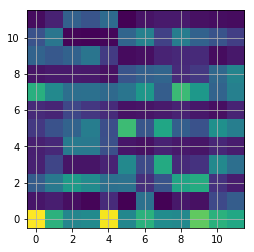

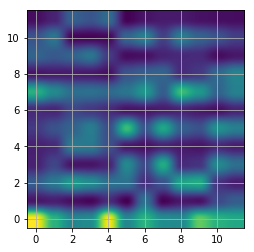

In [18]:
hpcparray=[];
for scale in scales:
    for i in range(len(globalFeatsData[scale]['mean_hpcp_vector'])):
        hpcparray.append(globalFeatsData[scale]['mean_hpcp_vector'][i])
globalhpcparray=np.array(hpcparray)
temp=globalhpcparray.transpose()
plt.figure(1)
plt.imshow(temp, interpolation='nearest',origin='lower')
plt.grid(True)

plt.figure(2)
plt.imshow(temp, interpolation='hanning',origin='lower')
plt.grid(True)